In [ ]:
! pip install mxnet
! pip install gluoncv

In [ ]:
import numpy as np

from pycocotools import coco
import mxnet as mx
import gluoncv as gcv
from gluoncv import model_zoo

import matplotlib.pyplot as plt
from skimage.io import imread
import pandas as pd
import seaborn as sns
import pylab

from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score, confusion_matrix

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

In [4]:
! unzip -q /content/gdrive/My\ Drive/test_tasks/archive.zip

In [5]:
def convert_to_mxnet(frame):
    return mx.nd.array(frame)

def transform_image(array):
    t = gcv.data.transforms.presets.yolo.transform_test(array, short=416)
    return t

def detect(network,data):
    prediction = network(data)
    class_ids, scores, bounding_boxes = prediction
    return class_ids, scores, bounding_boxes

def count_objects(network, class_ids, scores, bounding_boxes, object_labels, threshold=0.5):
    num_objects = 0
    classes = network.classes
    scores = scores.asnumpy().squeeze().astype(float)
    class_ids = class_ids.asnumpy().squeeze().astype(int)
    for index,i in enumerate(class_ids):
        if classes[i] in object_labels:
            if scores[index] >= threshold:
                num_objects += 1   
    return num_objects

class Objects_Counter():
    def __init__(self):
        self._network = model_zoo.get_model(model_used, pretrained=True)
        self._network.hybridize()

    def set_threshold(self, threshold):
        self._threshold = threshold
        
    def count(self, frame):
        norm_image, unnorm_image = transform_image(convert_to_mxnet(frame))
        class_ids, scores, bounding_boxes = detect(self._network, norm_image)
        num_objects = count_objects(self._network,
                                    class_ids,
                                    scores,
                                    bounding_boxes,
                                    threshold=self._threshold,
                                    object_labels=['car', 'bus', 'motorcycle', 'truck', 'person', 'bicycle'])
        return num_objects

    def class_names(self):
        return self._network.classes

In [6]:
class_names = ['clear', 'flush']

def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True')
    plt.xlabel('Predicted');

def conf_matr(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
    show_confusion_matrix(df_cm)

def estimation(true_labels, predicted_labels):
    f1 = round(f1_score(true_labels, predicted_labels), 2)
    accuracy = round(accuracy_score(true_labels, predicted_labels), 2)
    recall = round(recall_score(true_labels, predicted_labels), 2)
    precision = round(precision_score(true_labels, predicted_labels), 2)
    return f1, accuracy, recall, precision

In [ ]:
pylab.rcParams['figure.figsize'] = (8.0, 6.0)

rgbAnnFile = 'aauRainSnow-rgb.json'
thermalAnnFile = 'aauRainSnow-thermal.json'

rainSnowRgbGt = coco.COCO(rgbAnnFile)
rainSnowThermalGt = coco.COCO(thermalAnnFile)

In [ ]:
model_used = 'yolo3_darknet53_coco'
model_used = 'faster_rcnn_fpn_resnet101_v1d_coco'

counter = Objects_Counter()
counter.set_threshold(0.6)

In [ ]:
images, answers = [], []
true_labels, predict_labels = [], []
pixels = 640 * 480

for i in range(0, 2197):
    chosenImgId = i
    annIds = rainSnowRgbGt.getAnnIds(imgIds=[chosenImgId])
    anns = rainSnowRgbGt.loadAnns(annIds)
    rgbImg = rainSnowRgbGt.loadImgs([chosenImgId])[0]
    image = imread('./' + rgbImg['file_name'])
    if image.shape[2] != 3:
        continue
    images.append(image)

    unique, counts = np.unique(image, return_counts=True)
    flash_pixels_search = dict(zip(unique, counts))
    if 255 in flash_pixels_search.keys():
        flash = round(flash_pixels_search[255] / pixels, 2)
    else:
        flash = 0

    count = counter.count(image)

    if flash > 0.1: #0.05 --> 0.1
        true_labels.append(1)
    else:
        true_labels.append(0)

    if len(anns) * 0.4 > count: #0.5 --> 0.4
        predict_labels.append(1)
    else:
        predict_labels.append(0)

    if i % 50 == 0:
        counter = Objects_Counter()
        counter.set_threshold(0.6)

f1 score: 0.29
accuracy score: 0.84
recall score: 0.2
precision score: 0.52


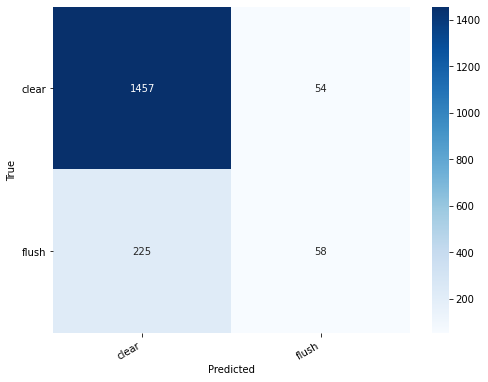

In [ ]:
flash_threshold = 0.15
vehicle_threshold = 0.5

f1, accuracy, recall, precision = estimation(true_labels, predict_labels)

print(f'f1 score: {f1}')
print(f'accuracy score: {accuracy}')
print(f'recall score: {recall}')
print(f'precision score: {precision}')

conf_matr(true_labels, predict_labels)

f1 score: 0.48
accuracy score: 0.53
recall score: 0.38
precision score: 0.67


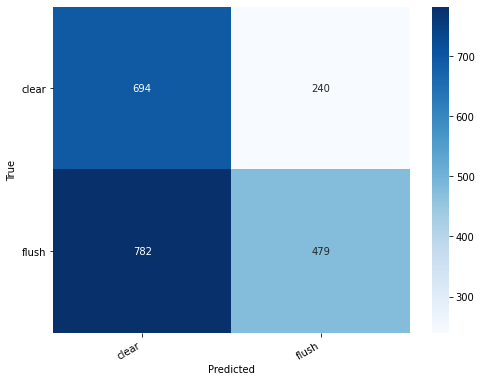

In [ ]:
flash_threshold = 0.05
vehicle_threshold = 0.5

f1, accuracy, recall, precision = estimation(true_labels, predict_labels)

print(f'f1 score: {f1}')
print(f'accuracy score: {accuracy}')
print(f'recall score: {recall}')
print(f'precision score: {precision}')

conf_matr(true_labels, predict_labels)

f1 score: 0.37
accuracy score: 0.63
recall score: 0.37
precision score: 0.37


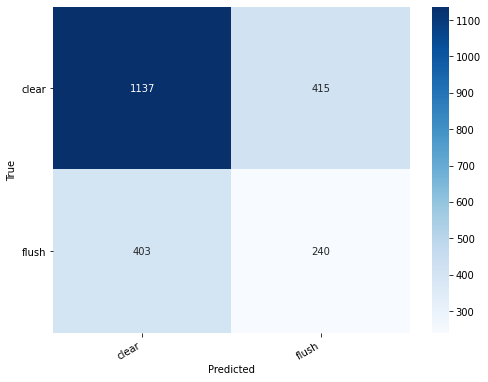

In [ ]:
flash_threshold = 0.1
vehicle_threshold = 0.4

f1, accuracy, recall, precision = estimation(true_labels, predict_labels)

print(f'f1 score: {f1}')
print(f'accuracy score: {accuracy}')
print(f'recall score: {recall}')
print(f'precision score: {precision}')

conf_matr(true_labels, predict_labels)

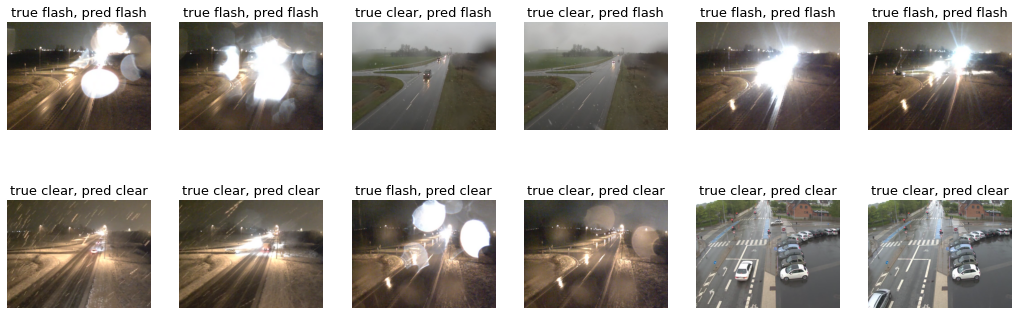

In [13]:
names = {0: 'clear', 1: 'flash'}

plt.figure(figsize = (18, 6))

for i in range(0, 6):
    plt.subplot(2, 6, i + 1)
    plt.axis('off')
    plt.title(f'true {names[true_labels[i]]}, pred {names[predict_labels[i]]}', fontdict={'fontsize': 13})
    plt.imshow(images[i])

    plt.subplot(2, 6, i + 7)
    plt.axis('off')
    plt.title(f'true {names[true_labels[i + 6]]}, pred {names[predict_labels[i + 6]]}', fontdict={'fontsize': 13})
    plt.imshow(images[i + 6])
    
plt.show()